<a href="https://colab.research.google.com/github/SebastianJanampa/LINEA/blob/master/LINEA_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!git clone https://github.com/SebastianJanampa/LINEA.git
%cd LINEA
!pip install -r requirements.txt
%cd ..
%cp LINEA/examples/example1.jpg example1.jpg

Cloning into 'LINEA'...
remote: Enumerating objects: 241, done.
remote: Counting objects: 100% (241/241), done.
remote: Compressing objects: 100% (126/126), done.
remote: Total 241 (delta 113), reused 233 (delta 108), pack-reused 0 (from 0)
Receiving objects: 100% (241/241), 2.84 MiB | 6.09 MiB/s, done.
Resolving deltas: 100% (113/113), done.
/content/LINEA
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 74.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
  

In [9]:
from LINEA.models.linea.hgnetv2 import build_hgnetv2
from LINEA.models.linea.hybrid_encoder import build_hybrid_encoder
from LINEA.models.linea.decoder import build_decoder
from LINEA.models.linea.linea import LINEA, PostProcess

def build_model(args):
  backbone = build_hgnetv2(args)
  encoder = build_hybrid_encoder(args)
  decoder = build_decoder(args)
  model = LINEA(backbone, encoder, decoder)
  post_process = PostProcess()
  return model, post_process

In [4]:
LINEA_MODELS = {
    'n': './LINEA/configs/linea/linea_hgnetv2_n.py',
    's': './LINEA/configs/linea/linea_hgnetv2_s.py',
    'm': './LINEA/configs/linea/linea_hgnetv2_m.py',
    'l': './LINEA/configs/linea/linea_hgnetv2_l.py'
}

model_size = 'l'

In [5]:
from LINEA.util.slconfig import DictAction, SLConfig

cfg = SLConfig.fromfile(LINEA_MODELS[model_size])
cfg.pretrained = False

In [6]:
import torch
from torch import nn

weigths_folder = './weights'
download_url = f"https://github.com/SebastianJanampa/storage/releases/download/LINEA/linea_hgnetv2_{model_size}.pth"
state = torch.hub.load_state_dict_from_url(download_url, map_location='cpu', model_dir=weigths_folder)

Downloading: "https://github.com/SebastianJanampa/storage/releases/download/LINEA/linea_hgnetv2_l.pth" to ./weights/linea_hgnetv2_l.pth
100%|██████████| 99.2M/99.2M [00:02<00:00, 38.9MB/s]


In [10]:
model, postprocessor = build_model(cfg)
checkpoint = torch.load(f"{weigths_folder}/linea_hgnetv2_{model_size}.pth", map_location='cpu')
model.load_state_dict(checkpoint['model'], strict=True)

class Model(nn.Module):
  def __init__(self):
    super().__init__()
    self.model = model.deploy()
    self.postprocessor = postprocessor.deploy()

  def forward(self, images, orig_target_sizes):
    outputs = self.model(images)
    outputs = self.postprocessor(outputs, orig_target_sizes)
    return outputs

model = Model()

In [11]:
import torchvision.transforms as T
from PIL import Image, ImageDraw

def draw(images, lines, scores, thrh):
    for i, im in enumerate(images):
        draw = ImageDraw.Draw(im)

        scr = scores[i]
        line = lines[i][scr > thrh]
        scrs = scr[scr > thrh]

        for j, l in enumerate(line):
            draw.line(list(l), fill="red", width=5)
            draw.text(
                (l[0], l[1]),
                text=f"{round(scrs[j].item(), 2)}",
                fill="blue",
            )

    return images


transforms = T.Compose(
        [
            T.Resize((640, 640)),
            T.ToTensor(),
            T.Normalize(mean=[0.538, 0.494, 0.453], std=[0.257, 0.263, 0.273]),
        ]
    )

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model.to(device)
model.eval()

img_file = 'example1.jpg'
im_pil = Image.open(img_file).convert("RGB")

w, h = im_pil.size
orig_size = torch.tensor([[w, h]]).to(device)

im_data = transforms(im_pil).unsqueeze(0).to(device)

output = model(im_data, orig_size)
lines, scores = output

result_images = draw([im_pil], lines, scores, thrh=0.4)

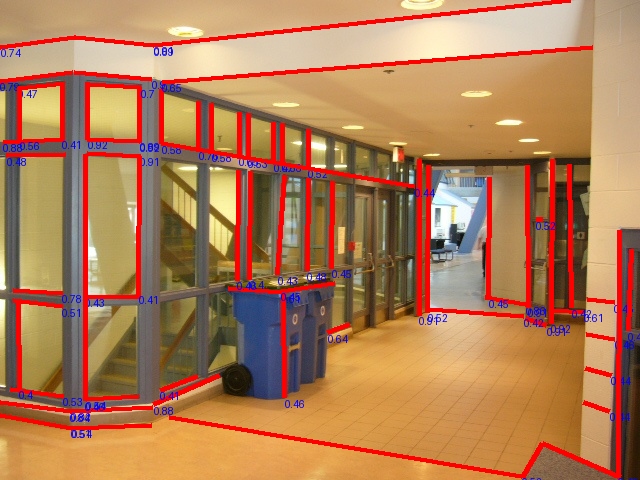

In [13]:
result_images[0]